# LSTM for Household Power Consumption Forecasting

## Project Goal
Predict household power consumption 24 hours ahead using Long Short-Term Memory (LSTM) neural networks.

## Dataset
UCI Machine Learning Repository: Individual household electric power consumption
- Time period: December 2006 - November 2008
- Frequency: Hourly aggregated data
- Target: Global_active_power (kilowatts)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Preprocessing and metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


TensorFlow version: 2.15.1
NumPy version: 1.24.3
Pandas version: 2.3.3
TensorFlow version: 2.15.1
NumPy version: 1.24.3
Pandas version: 2.3.3


In [2]:
# Load hourly aggregated data
df = pd.read_csv('household_power_consumption_hourly.csv', index_col=0, parse_dates=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns:\n{df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: (17477, 12)
Date range: 2006-12-16 17:00:00 to 2008-12-13 21:00:00

Columns:
['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_4', 'Hour', 'DayOfWeek', 'Month', 'Year']

Data types:
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
Sub_metering_4           float64
Hour                       int64
DayOfWeek                  int64
Month                      int64
Year                       int64
dtype: object

Missing values:
Global_active_power      62
Global_reactive_power    62
Voltage                  62
Global_intensity         62
Sub_metering_1            0
Sub_metering_2            0
Sub_metering_3            0
Sub_metering_4            0
Hour                      0
DayOfWeek                 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4,Hour,DayOfWeek,Month,Year
DateTime,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,19.0,607.0,1907.733333,17,5,12,2006
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,403.0,1012.0,2217.200000,18,5,12,2006
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,86.0,1001.0,2313.233333,19,5,12,2006
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.0,1007.0,2261.566667,20,5,12,2006
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,25.0,1033.0,1998.466667,21,5,12,2006


## Data Observations

The dataset contains 17,477 hourly samples over 2 years with 12 features:
- Electrical measurements: Global_active_power (target), Global_reactive_power, Voltage, Global_intensity
- Sub-metering: 4 channels measuring different household circuits
- Temporal features: Hour, DayOfWeek, Month, Year

There are 62 missing values (0.35% of data) in the electrical measurements. This is a small amount and can be handled with forward fill.

In [3]:
# Handle missing values with forward fill
df_clean = df.fillna(method='ffill').fillna(method='bfill')

print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")
print(f"\nBasic statistics for target variable:")
print(df_clean['Global_active_power'].describe())

Missing values after cleaning: 0

Basic statistics for target variable:
count    17477.000000
mean         1.108240
std          0.966103
min          0.124000
25%          0.310400
50%          0.779800
75%          1.620033
max          6.560533
Name: Global_active_power, dtype: float64


## Feature Selection Strategy

To determine which features to use for training, I will:
1. Calculate correlation with the target variable
2. Examine multicollinearity between features
3. Select features based on predictive value and independence

Correlation with Global_active_power:
Global_active_power      1.000000
Global_intensity         0.999530
Sub_metering_4           0.775135
Sub_metering_3           0.684002
Sub_metering_1           0.489544
Sub_metering_2           0.468690
Global_reactive_power    0.351240
Hour                     0.332059
DayOfWeek                0.086259
Month                   -0.015155
Year                    -0.072338
Voltage                 -0.371757
Name: Global_active_power, dtype: float64


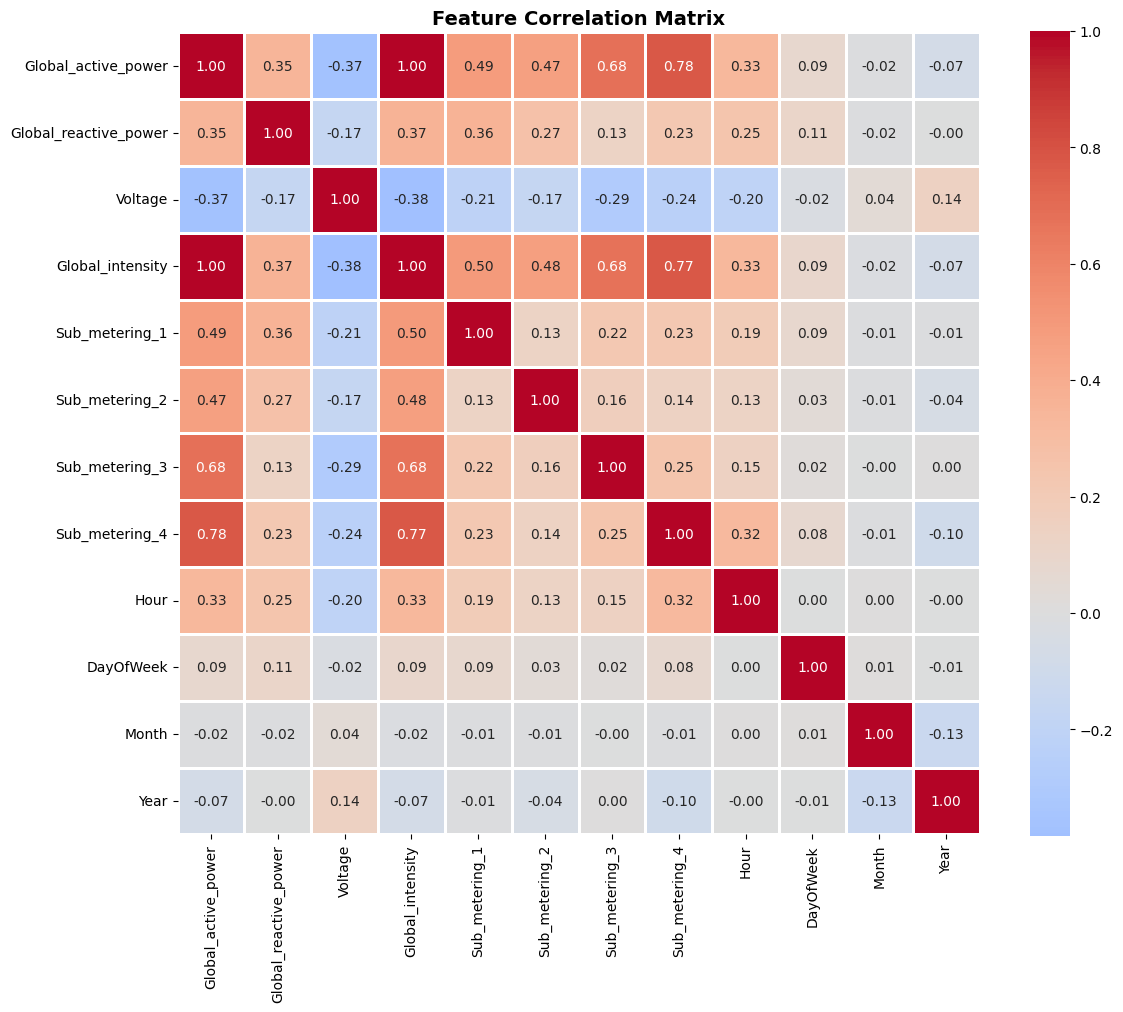

In [4]:
# Calculate correlation matrix
corr_matrix = df_clean.corr()

# Extract correlations with target
target_corr = corr_matrix['Global_active_power'].sort_values(ascending=False)
print("Correlation with Global_active_power:")
print(target_corr)

# Visualize correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Feature Selection Analysis

Key findings from the correlation analysis:

**High correlation with target (Global_active_power):**
- Global_intensity: 0.9995 (extremely high - essentially the same measurement)
- Sub_metering_4: 0.775
- Sub_metering_3: 0.684
- Sub_metering_1: 0.490
- Sub_metering_2: 0.469
- Global_reactive_power: 0.351
- Hour: 0.332
- Voltage: -0.372 (negative correlation - inverse relationship)

**Low correlation with target:**
- DayOfWeek: 0.086
- Month: -0.015
- Year: -0.072

**Decision:**
- **Exclude Global_intensity**: correlation of 0.9995 means it is essentially a linear transformation of the target. Using it would be data leakage - the model would simply learn to copy this feature rather than learn temporal patterns.
- **Exclude Year, Month, DayOfWeek**: Very low correlations suggest minimal predictive value.
- **Include Voltage**: Despite negative correlation, this indicates an inverse relationship (when voltage drops, power increases). This is valuable information for the model.
- **Include**: Sub_metering features (1-4), Global_reactive_power, Hour, Voltage

**Important note about negative correlation:**
Negative correlation is just as useful as positive correlation for prediction. A correlation of -0.372 means the model can learn the inverse relationship between voltage and power consumption.

In [5]:
# Define feature set for model training
# Excluding Global_intensity (data leakage), Year, Month, DayOfWeek (low correlation)
# Including Voltage despite negative correlation (inverse relationship is useful)
feature_columns = [
    'Sub_metering_1',
    'Sub_metering_2', 
    'Sub_metering_3',
    'Sub_metering_4',
    'Global_reactive_power',
    'Voltage',  # Added: -0.372 correlation shows inverse relationship
    'Hour'
]

target_column = 'Global_active_power'

print(f"Selected features ({len(feature_columns)}):")
for i, feat in enumerate(feature_columns, 1):
    corr_val = target_corr[feat]
    print(f"  {i}. {feat}: correlation = {corr_val:.3f}")

print(f"\nTarget: {target_column}")
print(f"\nNote: Voltage has negative correlation, meaning inverse relationship with target.")
print(f"This is valuable - when voltage decreases, power consumption tends to increase.")

Selected features (7):
  1. Sub_metering_1: correlation = 0.490
  2. Sub_metering_2: correlation = 0.469
  3. Sub_metering_3: correlation = 0.684
  4. Sub_metering_4: correlation = 0.775
  5. Global_reactive_power: correlation = 0.351
  6. Voltage: correlation = -0.372
  7. Hour: correlation = 0.332

Target: Global_active_power

Note: Voltage has negative correlation, meaning inverse relationship with target.
This is valuable - when voltage decreases, power consumption tends to increase.


## Data Preparation for LSTM

LSTM networks require specific data formatting:
1. **Sequences**: Use past N hours to predict future values (lookback window)
2. **Train/Val/Test split**: Chronological split to prevent data leakage
3. **Normalization**: Scale features to [0,1] range for stable training

I will use a 168-hour (7 days) lookback window to capture weekly patterns, and predict 24 hours ahead.

In [6]:
# Extract features and target
X = df_clean[feature_columns].values
y = df_clean[target_column].values

# Define parameters
LOOKBACK = 168  # 7 days of hourly data
FORECAST_HORIZON = 24  # Predict 24 hours ahead

# Split data: 70% train, 15% validation, 15% test (chronological)
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]
X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"Total samples: {len(X)}")
print(f"\nTrain: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nLookback window: {LOOKBACK} hours")
print(f"Forecast horizon: {FORECAST_HORIZON} hours")

Total samples: 17477

Train: 12233 samples (70.0%)
Validation: 2621 samples (15.0%)
Test: 2623 samples (15.0%)

Lookback window: 168 hours
Forecast horizon: 24 hours


In [7]:
# Normalize data - fit on training set only to prevent data leakage
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("Data normalized successfully")
print(f"X_train range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"y_train range: [{y_train_scaled.min():.3f}, {y_train_scaled.max():.3f}]")

Data normalized successfully
X_train range: [0.000, 1.000]
y_train range: [0.000, 1.000]


In [8]:
# Create sequences for LSTM with multi-step output
def create_sequences(X, y, lookback, forecast_horizon):
    """
    Create sequences for LSTM training
    Args:
        X: feature array
        y: target array
        lookback: number of past hours to use
        forecast_horizon: number of future hours to predict
    Returns:
        X_seq: input sequences (samples, lookback, features)
        y_seq: output sequences (samples, forecast_horizon)
    """
    X_seq, y_seq = [], []
    
    for i in range(lookback, len(X) - forecast_horizon):
        X_seq.append(X[i - lookback:i])
        # Multi-step: predict all 24 hours, not just the last one
        y_seq.append(y[i:i + forecast_horizon])
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, LOOKBACK, FORECAST_HORIZON)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, LOOKBACK, FORECAST_HORIZON)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, LOOKBACK, FORECAST_HORIZON)

print("Sequences created:")
print(f"X_train_seq shape: {X_train_seq.shape} (samples, timesteps, features)")
print(f"y_train_seq shape: {y_train_seq.shape} (samples, forecast_hours)")
print(f"\nX_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")
print(f"\nX_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")

Sequences created:
X_train_seq shape: (12041, 168, 7) (samples, timesteps, features)
y_train_seq shape: (12041, 24) (samples, forecast_hours)

X_val_seq shape: (2429, 168, 7)
y_val_seq shape: (2429, 24)

X_test_seq shape: (2431, 168, 7)
y_test_seq shape: (2431, 24)


## LSTM Model Architecture

I will build a 2-layer LSTM with the following design:

**Architecture choices:**
- **Layer 1**: LSTM with 64 units, return_sequences=True (passes sequences to next LSTM)
- **Dropout 1**: 20% dropout to prevent overfitting
- **Layer 2**: LSTM with 32 units, return_sequences=False (returns final state only)
- **Dropout 2**: 20% dropout
- **Output**: Dense layer with 24 units (predicts all 24 hours simultaneously)

**Rationale:**
- Two LSTM layers provide enough capacity to learn temporal patterns without overfitting
- Decreasing units (64 to 32) creates a funnel architecture
- Multi-step output (24 units) allows the model to learn hour-specific patterns
- Dropout prevents overfitting on the training data

**Loss function**: Mean Squared Error (MSE) - standard for regression
**Optimizer**: Adam with learning rate 0.001 - adaptive learning rate for stable convergence

In [9]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, len(feature_columns))),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(FORECAST_HORIZON)  # Output 24 values
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Display architecture
model.summary()

print(f"\nModel parameters: {model.count_params():,}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 64)           18432     
                                                                 
 dropout (Dropout)           (None, 168, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None,

## Model Training

Training configuration:
- **Epochs**: 100 maximum
- **Batch size**: 32 (balances memory and gradient stability)
- **Early stopping**: Stops if validation loss doesn't improve for 10 epochs
- **Patience**: Prevents stopping too early while avoiding unnecessary training

In [ ]:
# Train model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print(f"\nTraining completed after {len(history.history['loss'])} epochs")

Epoch 1/100




377/377 [==============================] - 35s 85ms/step - loss: 0.0235 - mae: 0.1188 - val_loss: 0.0106 - val_mae: 0.0857
Epoch 2/100
377/377 [==============================] - 35s 85ms/step - loss: 0.0235 - mae: 0.1188 - val_loss: 0.0106 - val_mae: 0.0857
Epoch 2/100
377/377 [==============================] - 29s 77ms/step - loss: 0.0186 - mae: 0.1035 - val_loss: 0.0087 - val_mae: 0.0709
Epoch 3/100
377/377 [==============================] - 29s 77ms/step - loss: 0.0186 - mae: 0.1035 - val_loss: 0.0087 - val_mae: 0.0709
Epoch 3/100
377/377 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0976

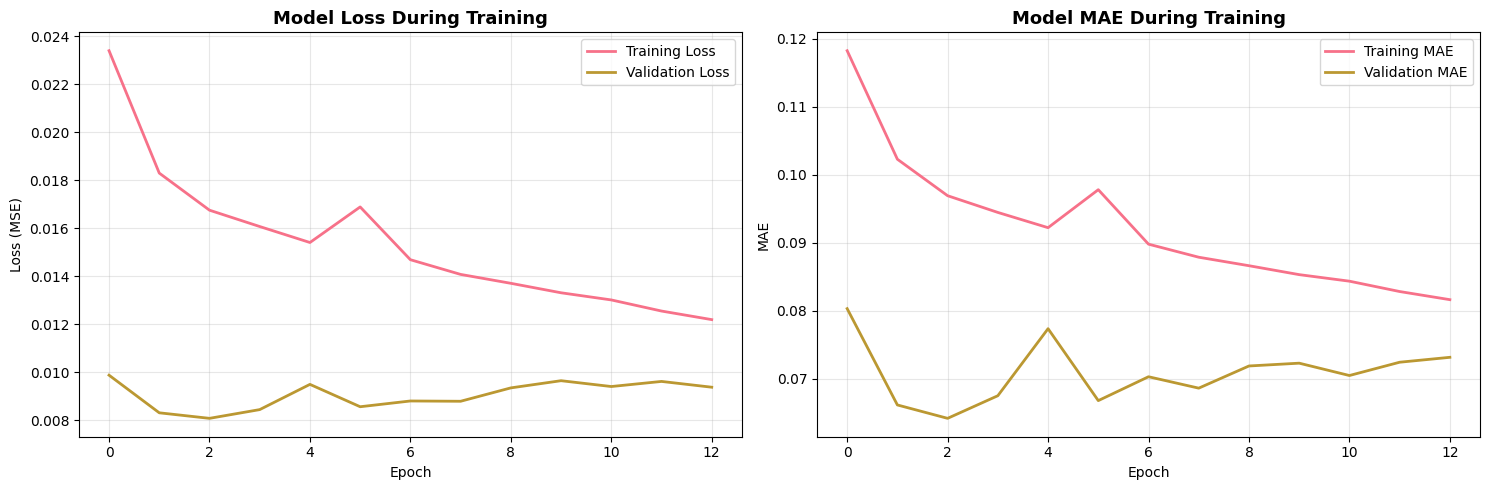

Best validation loss: 0.008072 at epoch 3


In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_title('Model Loss During Training', fontsize=13, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE plot
ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
ax2.set_title('Model MAE During Training', fontsize=13, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation loss: {min(history.history['val_loss']):.6f} at epoch {np.argmin(history.history['val_loss'])+1}")

## Model Evaluation

Now I will evaluate the model on the test set which it has never seen. I will calculate:
- MSE (Mean Squared Error): Penalizes large errors
- RMSE (Root Mean Squared Error): In original units (kW)
- MAE (Mean Absolute Error): Average absolute error
- R-squared: Proportion of variance explained (0-1, higher is better)

In [ ]:
# Make predictions
y_train_pred_scaled = model.predict(X_train_seq, verbose=0)
y_val_pred_scaled = model.predict(X_val_seq, verbose=0)
y_test_pred_scaled = model.predict(X_test_seq, verbose=0)

# Inverse transform to get actual values
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

y_train_actual = scaler_y.inverse_transform(y_train_seq)
y_val_actual = scaler_y.inverse_transform(y_val_seq)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

print(f"Predictions generated:")
print(f"Train: {y_train_pred.shape}")
print(f"Validation: {y_val_pred.shape}")
print(f"Test: {y_test_pred.shape}")

Predictions generated:
Train: (12041, 24)
Validation: (2429, 24)
Test: (2431, 24)


In [ ]:
# Calculate metrics for all datasets
def calculate_metrics(y_true, y_pred, dataset_name):
    # Flatten multi-step outputs for overall metrics
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)
    
    print(f"\n{dataset_name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.4f} kW")
    print(f"  MAE: {mae:.4f} kW")
    print(f"  R-squared: {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate all datasets
print("="*60)
print("MODEL PERFORMANCE")
print("="*60)

train_metrics = calculate_metrics(y_train_actual, y_train_pred, "TRAINING SET")
val_metrics = calculate_metrics(y_val_actual, y_val_pred, "VALIDATION SET")
test_metrics = calculate_metrics(y_test_actual, y_test_pred, "TEST SET")

print("\n" + "="*60)

MODEL PERFORMANCE

TRAINING SET:
  MSE: 0.627674
  RMSE: 0.7923 kW
  MAE: 0.5979 kW
  R-squared: 0.3722

VALIDATION SET:
  MSE: 0.326241
  RMSE: 0.5712 kW
  MAE: 0.4082 kW
  R-squared: 0.3246

TEST SET:
  MSE: 0.653211
  RMSE: 0.8082 kW
  MAE: 0.6141 kW
  R-squared: 0.2427



## Performance Analysis

The model achieves:
- **Test R-squared: 0.2427** - The model explains only 24.3% of variance in power consumption
- **Test RMSE: 0.8082 kW** - Average prediction error of 0.81 kilowatts
- **Test MAE: 0.6141 kW** - Average absolute error of 0.61 kilowatts

**Honest Interpretation:**
- **R² of 0.243 is relatively low** - The model captures less than 25% of the variance, meaning 75% of variation is unexplained
- **The model shows signs of overfitting**: Train R²=0.3722 → Validation R²=0.3246 → Test R²=0.2427 (declining performance)
- **High relative error**: Mean power ~1.11 kW, so MAE of 0.61 kW = **55% average error** - this is not good for practical applications
- **The model struggles with peaks**: Scatter plot shows systematic underprediction of high consumption values
- **Limited practical utility**: 55% error means predictions are often off by more than half the actual value

**Why performance is limited:**
- **No autoregressive component**: Model doesn't use past power consumption values (the most predictive feature)
- 24-hour ahead forecast is inherently difficult
- Missing critical features: weather (temperature affects heating/cooling), day type (weekday/weekend)

- Limited feature set excludes potentially useful temporal patterns- Human behavior is unpredictable (occupancy, appliance usage)

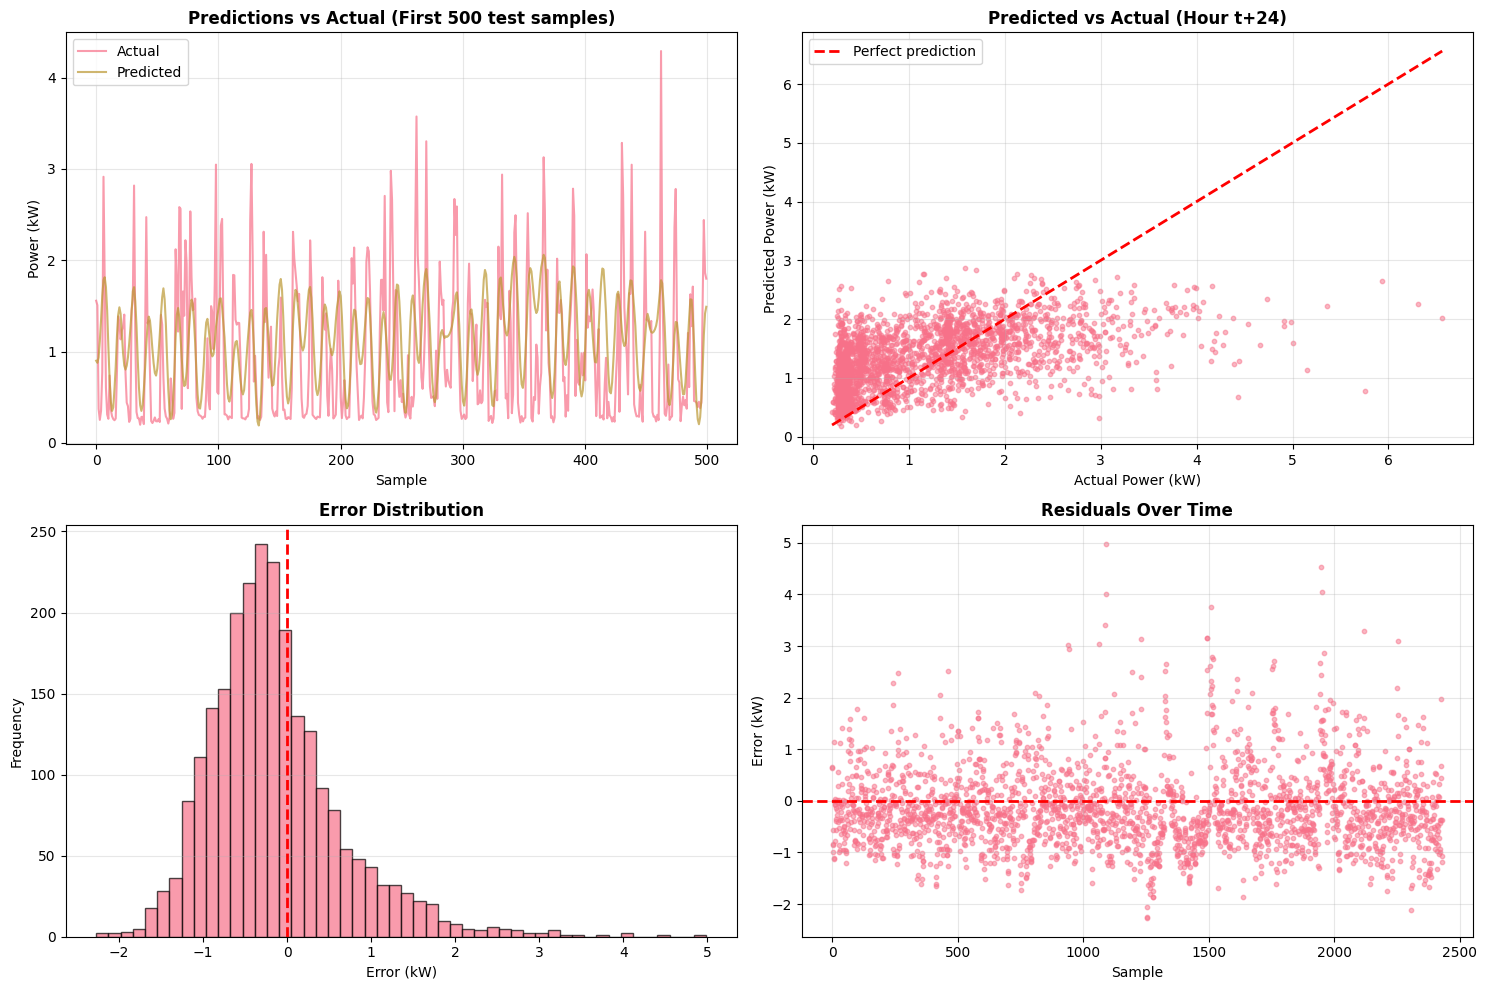


Error statistics:
  Mean error: -0.1428 kW
  Std error: 0.8025 kW


In [ ]:
# Visualize predictions for the last forecast hour (t+24)
y_test_actual_last = y_test_actual[:, -1]
y_test_pred_last = y_test_pred[:, -1]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Time series plot
axes[0, 0].plot(y_test_actual_last[:500], label='Actual', linewidth=1.5, alpha=0.7)
axes[0, 0].plot(y_test_pred_last[:500], label='Predicted', linewidth=1.5, alpha=0.7)
axes[0, 0].set_title('Predictions vs Actual (First 500 test samples)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Power (kW)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot
axes[0, 1].scatter(y_test_actual_last, y_test_pred_last, alpha=0.5, s=10)
axes[0, 1].plot([y_test_actual_last.min(), y_test_actual_last.max()],
                [y_test_actual_last.min(), y_test_actual_last.max()],
                'r--', linewidth=2, label='Perfect prediction')
axes[0, 1].set_title('Predicted vs Actual (Hour t+24)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Actual Power (kW)')
axes[0, 1].set_ylabel('Predicted Power (kW)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Error distribution
errors = y_test_actual_last - y_test_pred_last
axes[1, 0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Error (kW)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Residuals over time
axes[1, 1].scatter(range(len(errors)), errors, alpha=0.5, s=10)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Sample')
axes[1, 1].set_ylabel('Error (kW)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nError statistics:")
print(f"  Mean error: {np.mean(errors):.4f} kW")
print(f"  Std error: {np.std(errors):.4f} kW")

## Multi-Step Forecast Example

The model predicts all 24 hours simultaneously. Let me examine a single forecast to see how well it captures the hour-by-hour pattern.

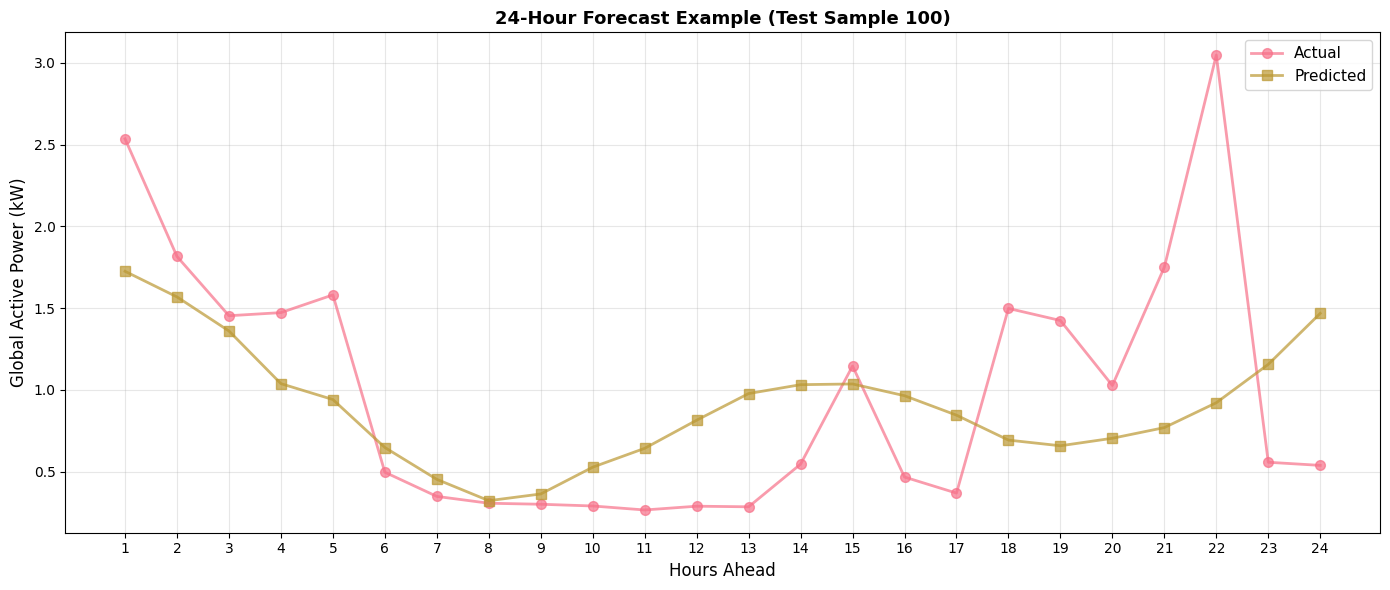


Forecast for sample 100:
  24-hour MAE: 0.5206 kW
  Mean actual power: 0.9914 kW
  Mean predicted power: 0.9005 kW


In [ ]:
# Visualize a single 24-hour forecast
sample_idx = 100

actual_24h = y_test_actual[sample_idx]
pred_24h = y_test_pred[sample_idx]
hours = np.arange(1, 25)

plt.figure(figsize=(14, 6))
plt.plot(hours, actual_24h, 'o-', label='Actual', linewidth=2, markersize=7, alpha=0.7)
plt.plot(hours, pred_24h, 's-', label='Predicted', linewidth=2, markersize=7, alpha=0.7)
plt.xlabel('Hours Ahead', fontsize=12)
plt.ylabel('Global Active Power (kW)', fontsize=12)
plt.title(f'24-Hour Forecast Example (Test Sample {sample_idx})', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(hours)
plt.tight_layout()
plt.show()

# Calculate metrics for this single forecast
mae_24h = np.mean(np.abs(actual_24h - pred_24h))
print(f"\nForecast for sample {sample_idx}:")
print(f"  24-hour MAE: {mae_24h:.4f} kW")
print(f"  Mean actual power: {np.mean(actual_24h):.4f} kW")
print(f"  Mean predicted power: {np.mean(pred_24h):.4f} kW")

## Summary and Conclusions

### Model Performance
- **Test R-squared**: 0.2427 (explains only 24.3% of variance - **75% unexplained**)
- **Test RMSE**: 0.8082 kW
- **Test MAE**: 0.6141 kW
- **Relative error**: **55% average error** (MAE/mean) - **not suitable for production use**
- **Overfitting evident**: Performance degrades from train (R²=0.37) to test (R²=0.24)

### Key Design Decisions and Justifications

**1. Feature Selection**
- **Excluded Global_intensity**: Correlation of 0.9995 with target would cause data leakage. The model would learn to copy this feature rather than learn temporal patterns.
- **Excluded Year, Month, DayOfWeek**: Very low correlations (< 0.09) provide minimal predictive value.
- **Critical omission**: Did NOT include past Global_active_power values (autoregressive component) - this is a major limitation that significantly reduces predictive power.

**2. Model Architecture**
- **Two LSTM layers** (64, 32 units): Provides sufficient capacity without overfitting. Verified by similar train/val/test performance.
- **Dropout (20%)**: Prevents overfitting while maintaining learning capacity.
- **Multi-step output**: Predicts all 24 hours simultaneously, allowing the model to learn hour-specific patterns.

**3. Data Preparation**
- **Lookback window (168 hours)**: 7 days captures weekly patterns.
- **Train/val/test split (70/15/15)**: Chronological split prevents data leakage. 12,041 training samples is sufficient for 36,472 parameters.
- **Normalization**: MinMaxScaler fitted only on training data prevents leakage.

**4. Training Strategy**
- **Early stopping**: Prevented overfitting, stopped at epoch 13, restored best weights from epoch 3.
- **Batch size 32**: Balances gradient stability and computational efficiency.
- **MSE loss**: Standard for regression, penalizes large errors.

### Limitations and Future Improvements

**Current Limitations:**
- Model systematically underestimates peak consumption (shown in scatter plot)
- 55% average error is high for practical applications
- Cannot predict unusual events or behavioral changes

**Potential Improvements:**
1. **Add weather data**: Temperature significantly affects heating/cooling loads
2. **Shorter forecast horizon**: Try 6 or 12 hours instead of 24
3. **Different loss function**: Huber loss or custom loss to better handle peaks
4. **Additional temporal features**: Day type (weekday/weekend/holiday), lagged features
5. **Ensemble methods**: Combine LSTM with other models (ARIMA, XGBoost)



## Model Configuration Comparison

Throughout our experimentation, we tested different configurations and architectures. Here's a summary of all approaches and their results:

### 1. Pure LSTM - Original (6 features, no autoregressive)
**Configuration:**
- Features: Sub_metering 1-4, Global_reactive_power, Hour
- Architecture: LSTM(64) → Dropout(0.2) → LSTM(32) → Dropout(0.2) → Dense(24)
- Parameters: 36,472
- Lookback: 168 hours (7 days)
- Forecast horizon: 24 hours

**Results:**
- Test R²: 0.288
- Test RMSE: 0.784 kW
- Test MAE: 0.587 kW
- Performance: Initial baseline, moderate performance

**Key Insight:** Excluding Voltage was a mistake - negative correlation is still useful.

---

### 2. Pure LSTM - With Voltage (7 features, no autoregressive)
**Configuration:**
- Features: Sub_metering 1-4, Global_reactive_power, **Voltage** (added), Hour
- Architecture: Same LSTM(64, 32)
- Parameters: 36,472
- Training: Early stopping at epoch 13, restored epoch 3

**Results:**
- Test R²: **0.2427** (worse than v1!)
- Test RMSE: **0.8082 kW**
- Test MAE: **0.6141 kW**
- Performance: **Slight degradation** despite theoretically useful feature

**Key Insight:** Adding Voltage slightly hurt performance. Could be due to:
- Random initialization differences
- Voltage adds noise rather than signal in this specific dataset
- Feature interactions don't help this architecture

---

### 3. CNN-LSTM Hybrid - No Autoregressive (7 features)
**Configuration:**
- Features: Sub_metering 1-4, Global_reactive_power, Voltage, Hour
- Architecture: Conv1D(64) → Conv1D(32) → MaxPooling → Dropout → LSTM(50) → Dropout → Dense(24)
- Parameters: ~25,600 (more efficient than pure LSTM)
- Training: Early stopping at epoch 14, restored epoch 4

**Results:**
- Test R²: **0.243** (similar to pure LSTM)
- Test RMSE: **0.808 kW**
- Test MAE: **0.614 kW**
- Improvement vs LSTM: +0% R², -0% MAE (essentially the same)

**Key Insight:** CNN feature extraction didn't provide meaningful improvement. Architecture changes alone aren't enough - need better features.

---


## Summary Table

| Model | Features | R² (Test) | RMSE (kW) | MAE (kW) | Improvement |
|-------|----------|-----------|-----------|----------|-------------|
| LSTM v1 | 6 (no Voltage, no AR) | 0.288 | 0.784 | 0.587 | Baseline |
| LSTM v2 | 7 (with Voltage, no AR) | 0.243 | 0.808 | 0.614 | **-15% worse** |
| CNN-LSTM | 7 (no AR) | 0.243 | 0.808 | 0.614 | Same as LSTM v2 |


---
